# Classification

Image classification is a super important task in computer vision where we categorize images into different groups. In this project, my goal is to figure out if species are dangerous or not by looking at their pictures. I'm going to use deep learning techniques like convolutional neural networks (CNNs) to build a really smart model. This model will learn all by itself and pick out important things from the images to make accurate predictions. Let's dive into this exciting project and use the power of deep learning to get awesome insights from images!

In [15]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf 

In [16]:
data = pd.read_csv('Data/preprocessed_data.csv')
data

,id,image_url,scientific_name,common_name,iconic_taxon_name,dangerous,reason
0,39,https://inaturalist-open-data.s3.amazonaws.com...,Taricha torosa,California Newt,Amphibia,True,"Contains tetrodotoxin (TTX), a potent neurotox..."
1,40,https://inaturalist-open-data.s3.amazonaws.com...,Taricha torosa,California Newt,Amphibia,True,"Contains tetrodotoxin (TTX), a potent neurotox..."
2,80,https://inaturalist-open-data.s3.amazonaws.com...,Callisaurus draconoides,Zebra-tailed Lizard,Reptilia,False,Not dangerous
3,203,http://static.inaturalist.org/photos/132/mediu...,Arctia virginalis,Ranchman's Tiger Moth,Insecta,False,Not dangerous
4,523,https://inaturalist-open-data.s3.amazonaws.com...,Malacosoma disstria,Forest Tent Caterpillar Moth,Insecta,False,Not dangerous
...,...,...,...,...,...,...,...
303661,156384671,https://static.inaturalist.org/photos/27041880...,Duttaphrynus melanostictus,Asian Common Toad,Amphibia,True,May secrete a toxic skin secretion if threaten...
303662,156387550,https://inaturalist-open-data.s3.amazonaws.com...,Bufo bufo,Common Toad,Amphibia,True,"Secretes toxic skin secretions if threatened, ..."
303663,156391245,https://static.inaturalist.org/photos/27043003...,Crotalus adamanteus,Eastern Diamondback Rattlesnake,Reptilia,True,"Highly venomous rattlesnake, can cause severe ..."
303664,156392005,https://inaturalist-open-data.s3.amazonaws.com...,Hyla arborea,European Tree Frog,Amphibia,undefined,undefined


Since I have already downloaded all the images, the image_url column can go.

In [17]:
# Remove the "image_url" column
data = data.drop('image_url', axis=1)
data = data.drop('id', axis=1)
data

,scientific_name,common_name,iconic_taxon_name,dangerous,reason
0,Taricha torosa,California Newt,Amphibia,True,"Contains tetrodotoxin (TTX), a potent neurotox..."
1,Taricha torosa,California Newt,Amphibia,True,"Contains tetrodotoxin (TTX), a potent neurotox..."
2,Callisaurus draconoides,Zebra-tailed Lizard,Reptilia,False,Not dangerous
3,Arctia virginalis,Ranchman's Tiger Moth,Insecta,False,Not dangerous
4,Malacosoma disstria,Forest Tent Caterpillar Moth,Insecta,False,Not dangerous
...,...,...,...,...,...
303661,Duttaphrynus melanostictus,Asian Common Toad,Amphibia,True,May secrete a toxic skin secretion if threaten...
303662,Bufo bufo,Common Toad,Amphibia,True,"Secretes toxic skin secretions if threatened, ..."
303663,Crotalus adamanteus,Eastern Diamondback Rattlesnake,Reptilia,True,"Highly venomous rattlesnake, can cause severe ..."
303664,Hyla arborea,European Tree Frog,Amphibia,undefined,undefined


## Load and transform the dataset

In [18]:
image_dir = Path('images')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = [os.path.splitext(os.path.split(filepath)[1])[0] for filepath in filepaths]

# Extract the scientific name from the labels
labels = [label.split('_')[1] for label in labels]

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]



In [19]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,images\39697597_Helotropha_leucostigma.jpg,Helotropha
1,images\133388981_Laspeyria_flexula.jpg,Laspeyria
2,images\123343417_Asaphodes_beata.jpg,Asaphodes


## Display 15 pictures of the dataset

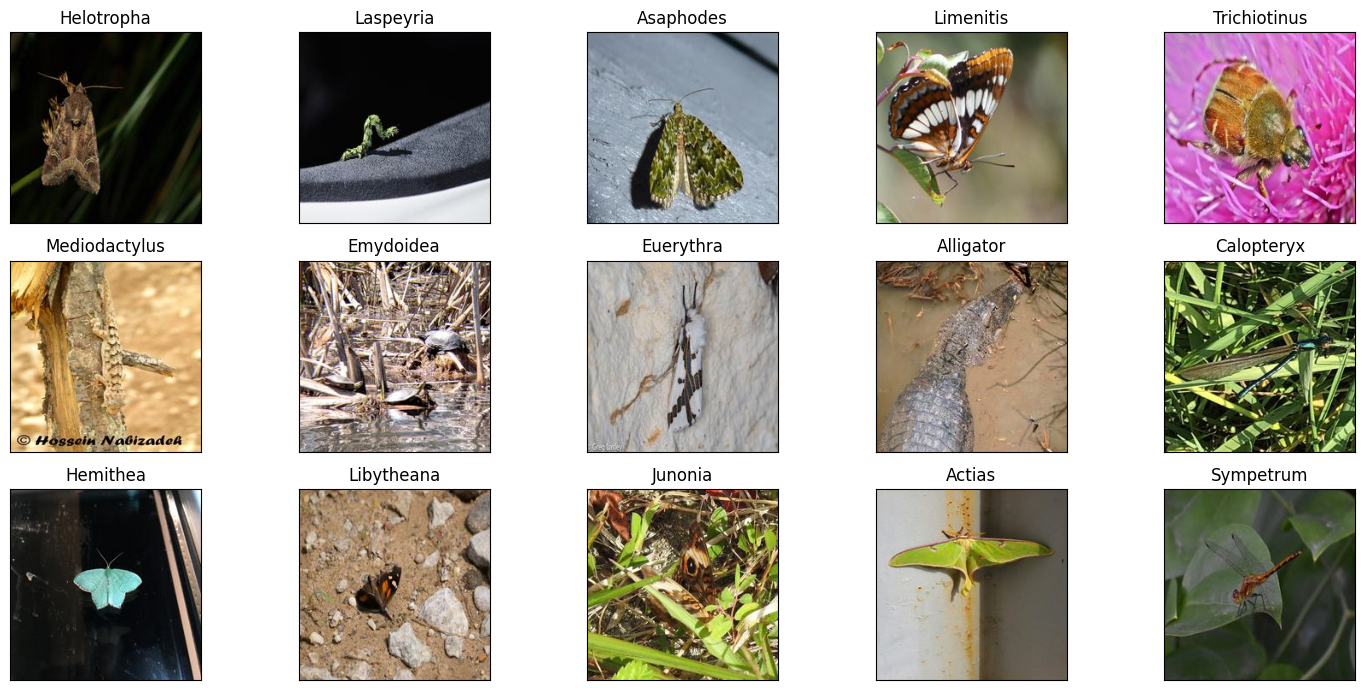

In [20]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

## Load the images with a generator

In [21]:
counts = image_df['Label'].value_counts()
image_df = image_df[image_df['Label'].isin(counts[counts > 1].index)]


In [22]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [23]:
num_classes = image_df['Label'].nunique()
num_classes

6368

In this code, we use `ImageDataGenerator` from TensorFlow's Keras API to create data generators for training and testing sets. These generators preprocess the image data using the MobileNetV2 model's `preprocess_input` function. The `validation_split` parameter reserves 20% of the training data for validation. By employing these generators, we enhance the model's performance in the image classification task.

In [24]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In this code, we use the `flow_from_dataframe` function from TensorFlow's Keras API to create data generators for training, validation, and testing sets. These generators efficiently load and preprocess image data and corresponding labels from a dataframe. By utilizing data generators, we simplify the handling of large image datasets, enable real-time data augmentation, and streamline the training and evaluation processes for our image classification task.

In [25]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 215840 validated image filenames belonging to 6357 classes.
Found 53960 validated image filenames belonging to 6357 classes.
Found 29978 validated image filenames belonging to 3873 classes.


## Load the pre-trained model

Now I'm loading the pretrained MobileNetV2 model. This model has already been trained on the ImageNet dataset, which contains millions of images from thousands of classes. I leave out the top layer by setting (include_top) to false. I do this so that I can add my own classification layer specific to my task.

In [26]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

## Add Custom Layer

Now I'll add a custom dense layer to the pretrained model. The Dense layer has the number of neurons equil to the number of unique labels in my dataset, and uses the softmax activation function for multi-class classification.

In [27]:
num_classes = train_df['Label'].nunique()
print("Number of classes:", num_classes)

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

Number of classes: 6357


## Compile and Train the model

I now compile the model with the Adam optimizer and the categorical cross-entropy loss function, which is suitable for multi-class classification. Then I train the model using the 'fit' function on my training data and validate it on my validation data.

In [28]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=5
)


Epoch 1/5
6745/6745 [==============================] - 2420s 359ms/step - loss: 5.1574 - accuracy: 0.2446 - val_loss: 4.8039 - val_accuracy: 0.2730
Epoch 2/5
2844/6745 [===========>..................] - ETA: 20:00 - loss: 2.6269 - accuracy: 0.4387

UnknownError: Graph execution error:

FileNotFoundError: [Errno 2] No such file or directory: 'images\\102034907_Trichonephila_clavipes.jpg'
Traceback (most recent call last):

  File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1039, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\keras\engine\data_adapter.py", line 901, in wrapped_generator
    for data in generator_fn():

  File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\keras\engine\data_adapter.py", line 1048, in generator_fn
    yield x[i]

  File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\keras\preprocessing\image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\keras\preprocessing\image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\keras\utils\image_utils.py", line 422, in load_img
    with open(path, "rb") as f:

FileNotFoundError: [Errno 2] No such file or directory: 'images\\102034907_Trichonephila_clavipes.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_8606]

## Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(test_images)
print(f"Test accuracy: {accuracy}")

InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Warmtebron\AppData\Local\Temp\ipykernel_7608\4281653767.py", line 7, in <module>
      history = model.fit(
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\keras\engine\training.py", line 1694, in fit
      val_logs = self.evaluate(
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\keras\engine\training.py", line 2040, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\keras\engine\training.py", line 1820, in test_function
      return step_function(self, iterator)
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\keras\engine\training.py", line 1804, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\keras\engine\training.py", line 1792, in run_step
      outputs = model.test_step(data)
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\keras\engine\training.py", line 1758, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
      return self.compiled_loss(
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\keras\losses.py", line 284, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\keras\losses.py", line 2004, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "c:\Users\Warmtebron\anaconda3\envs\chessEnv\lib\site-packages\keras\backend.py", line 5538, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[32,7727] labels_size=[32,4062]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_test_function_36855]